In [1]:
#%matplotlib inline

# %load_ext autoreload
# %autoreload 2

import time
import os
import logging
#from functools import wraps
from copy import deepcopy
import dill
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import numpy as np
import itertools
import pickle
import pandas as pd
#from tqdm.autonotebook import tqdm, trange

# from IPython.display import display
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from pypalettes import get_hex

# torch packages
import torch
import torch.optim as optim
import torch.nn as nn

from torch.nn.functional import mse_loss, l1_loss
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.transforms import v2
#from torchvision.utils import make_grid
from torchsummary import summary

#import torch.nn.functional as F

FILENAME = 'STATS_Autoenc_SIC_'

if '../src/modules/' not in sys.path:
    sys.path.append('../src/modules/')

from plot_jupyter import contour_compare, contour_data
from data_wrangle import get_days_before, get_test_set, window_mean, get_days_after
from autoenc_lowres import Encoder, Decoder, MLP_enc_SIC, MLP_dec_SIC
from autoenc_highres import Encoder_sharp, Decoder_sharp, Encoder_sharp_1024, Decoder_sharp_1024
from sic_data_functions import get_ice_data, thin_data, iiee_calc, normalise_image, test_data_stats, thousands,millions, multiple_dfs_to_excel

batched_iiee = torch.func.vmap(iiee_calc)
batched_min = torch.func.vmap(torch.min)
batched_max = torch.func.vmap(torch.max)


formatter = FuncFormatter(thousands)


formatter_mil = FuncFormatter(millions)

In [2]:
"""Directories"""

pkl_dir = r'../outputs/pkl/'
stats_dir = r'../outputs/stats/'


In [3]:
#seed for repeatable results
torch.manual_seed(0)

gen1 = torch.Generator().manual_seed(0)

epochs = 1000 #400

# if training needs to be run
run_training = False

run_sharp = True

clamp_yn = True
norm_yn = False

if not run_sharp:
    lowres = 'lowres_'
    imported_enc, imported_dec = Encoder, Decoder
else:
    lowres = 'sharp_'
    imported_enc, imported_dec = Encoder_sharp_1024, Decoder_sharp_1024 


if not run_training:
    load_ext = True
    model_enc = '../outputs/final/enc_sharp_64_1291_optimal_20240818'
    model_dec = '../outputs/final/dec_sharp_64_1291_optimal_20240818'
else:
    load_ext = False

In [4]:
sic_data, m , x,y,Y_mean_month, Y_mean_week = get_ice_data(return_all = True)

if not run_sharp:
    sic_data,_ = thin_data(sic_data,m,3)
del m

In [5]:
year = 32 # year within data set
day = 0 # day within year as the starting point 
window = 1 # window-averaging
num_year_data = 32 # number of years worth of data
T_train = 365 * num_year_data  # how many days worth of data needed
batchSize = 210  #215 #batch size for dataloader will vary PC to PC
dim_latent = 64 #2,4,8,16,24,32,
T_test = 365*2

train_split = int(num_year_data*0.8) * 365
val_split = num_year_data *365 - train_split


# X0_ = get_days_before(sic_data, year, day, T_train+window-1) # get days from DATA
# X1_ = get_days_after(sic_data, year, day,T_test)

# if window > 1:
#     X0_ = window_mean(X0_, window = window, t = None) # compute window mean, 
#     X1_ = get_test_set(sic_data, year, day, window, T_test)
# X0_.shape, X1_.shape


# X0_ = get_days_before(sic_data, year, day, T_train+window-1)
# X1_ = get_days_after(sic_data, year, day,  365*2)

In [6]:
with open(model_enc, 'rb') as f:
    loaded_enc = torch.load(f)
with open(model_dec, 'rb') as f:
    loaded_dec = torch.load(f)

loaded_enc.eval()
loaded_dec.eval()

# loaded_enc_cpu = loaded_enc.cpu()
# loaded_dec_cpu = loaded_dec.cpu()

loaded_enc.to("cuda")
loaded_dec.to("cuda")

Decoder_sharp_1024(
  (layers): Sequential(
    (0): Linear(in_features=64, out_features=1024, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(64, 4, 4))
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(4, 4))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (9): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (10): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(4, 4))
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(1, 1))
    (14): ConvTranspose2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
    (15): ConvTranspose2d(8, 8, kernel_size=(5, 5), stride=(2, 2))


In [7]:
""" Uncomment to run: Chart for latent space size  vs reconstruction error"""

# latent_dir = r'../outputs/latent_verify/latent_mse/'  #change directory to run MSE or MAE version
# latent_size = [2,4,8,16,24,32,64]
# epoch = 1000

# latent_avg_stat = []
# latent_MSE = []
# latent_MAE = []
# latent_IIEE = []

# for i in latent_size:
#   enc_name = 'enc_{:}{:}_{:}'.format(lowres,i,epoch)
#   dec_name = 'dec_{:}{:}_{:}'.format(lowres, i,epoch)
#   with open(latent_dir + enc_name, 'rb') as f:
#     loaded_enc = torch.load(f)
#   with open(latent_dir + dec_name, 'rb') as f:
#     loaded_dec = torch.load(f)

#   loaded_enc_cpu = loaded_enc.cpu()
#   loaded_dec_cpu = loaded_dec.cpu()
  
#   test_loss_tuple = test_data_stats(X1_,clamp_yn,norm_yn,loaded_enc_cpu, loaded_dec_cpu)

#   latent_avg_stat.append(pd.concat((pd.DataFrame([i]),pd.DataFrame(test_loss_tuple[0])), axis = 1, ignore_index= True))
#   latent_MSE.append(pd.concat((pd.DataFrame([i]),pd.DataFrame(test_loss_tuple[1])), axis = 1, ignore_index= True))
#   latent_MAE.append(pd.concat((pd.DataFrame([i]),pd.DataFrame(test_loss_tuple[2])), axis = 1, ignore_index= True))
#   latent_IIEE.append(pd.concat((pd.DataFrame([i]),pd.DataFrame(test_loss_tuple[3])), axis = 1, ignore_index= True))


# latent_avg_stat_df = pd.concat(latent_avg_stat, ignore_index = True)

# column_indices = [0,1,2,3]
# new_names = ['Latent Size','MSE','MAE','IIEE']
# old_names = latent_avg_stat_df.columns[column_indices]
# latent_avg_stat_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)


# import seaborn as sns

# fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# pal = sns.color_palette("husl")
# print(pal.as_hex())

# fig.suptitle("Reconstruction error per Latent space size")
# fig.subplots_adjust(top=0.85)
# sns.set_palette("husl",8)

# ax_sns_1 = sns.pointplot(data = latent_avg_stat_df,x='Latent Size', y='MSE', ax = axs[0],color= '#36ada4').set_title("MSE")

# ax_sns_2 = sns.pointplot(data = latent_avg_stat_df,x='Latent Size', y='IIEE', ax = axs[1],color= '#3ba3ec').set_title("Avg IIEE")


' Uncomment to run: Chart for latent space size  vs reconstruction error'

In [8]:
""" Uncomment to run: Save down latent space for LSTM training:"""

# windows = [1,5,10,20]
# #windows = [1]

# loaded_enc.to("cuda")

# for i in windows:
#     X0_ = get_days_before(sic_data, year, day, T_train+i-1) # get days from DATA
#     X1_ = get_days_after(sic_data, year, day,T_test)

#     if window > 1:
#         X0_ = window_mean(X0_, window = i, t = None) # compute window mean, 
#         X1_ = get_test_set(sic_data, year, day, i, T_test)
#     X0_.shape, X1_.shape

#     train_loader_sic = torch.utils.data.DataLoader(dataset=torch.Tensor(X0_[:,None,:,:]), batch_size=300, shuffle=False)
    
#     encoded_temp = []

#     for _, dat in enumerate(train_loader_sic):
#         img = dat.to("cuda") 
#         latent_train_temp = loaded_enc(img).detach().cpu()
#         encoded_temp.append(latent_train_temp)

#     latent_train = torch.concatenate(encoded_temp)
#     pkl_out_train = r'../outputs/lstm_latent/' + 'latent_win_{:}_train'.format(i)
#     pkl_out_test = r'../outputs/lstm_latent/' + 'latent_win_{:}_test'.format(i)

#     with open(pkl_out_train, 'wb') as output:
#         pickle.dump(latent_train, output)
#     #del latent_train
    
#     latent_test = loaded_enc(torch.Tensor(X1_)[:,None,:,:].to("cuda")).detach().cpu()
#     with open(pkl_out_test, 'wb') as output:
#         pickle.dump(latent_test, output)
#     #del latent_test

' Uncomment to run: Save down latent space for LSTM training:'

In [9]:
""" Uncomment to run: BOPDMD reconstruction and sequential forecast: """

from pydmd import DMD, BOPDMD

#window history svdrank
best_win_his = [(1,2,5),(5,7,5),(10,2,5),(20,2,7)]

pred_range = 180

#windows = [1,5,10,20]
windows = [1]

#num_prev_yrs = [2,5,7,10]
num_prev_yrs = [2]
#num_prev_yrs = [2,7]

#svd_ranks = [3,4,5,6,7,8,9,10]
svd_ranks = [5]
#svd_ranks = [5,7]

#dmd_latent_stats = []
dmd_avg_stat = []
dmd_MSE = []
dmd_MAE = []
dmd_IIEE = []
dmd_latent_recon = []
dmd_latent_fwd = []
latent_space = []
latent_space_pred = []
latent_space_true = []
dmd_true_integral =[]
dmd_pred_integral =[]

for w in windows:
    X0_ = get_days_before(sic_data, year, day, T_train+w-1) # get days from DATA
    X1_ = get_days_after(sic_data, year, day,T_test)

    if w > 1:
        X0_ = window_mean(X0_, window = w, t = None) # compute window mean, 
        X1_ = get_test_set(sic_data, year, day, w, T_test)
    X0_.shape, X1_.shape

    all_data = torch.Tensor(X0_)[:,None,:,:]

    for j in num_prev_yrs:
        
        train_loader_sic = torch.utils.data.DataLoader(dataset=all_data[-(365 * j):,...], batch_size=400, shuffle=False)
        test_loader_sic = torch.utils.data.DataLoader(dataset=torch.Tensor(X1_)[:,None,:,:], batch_size=400, shuffle=False)

        encoded_train_temp = []
        encoded_test_temp = []

        for _, dat in enumerate(train_loader_sic):
            img = dat.to("cuda") 
            latent_train_temp = loaded_enc(img).detach().cpu()
            encoded_train_temp.append(latent_train_temp)

        enc_train_dmd = torch.concatenate(encoded_train_temp).detach().cpu().numpy()

        for _, dat in enumerate(test_loader_sic):
            img = dat.to("cuda") 
            latent_test_temp = loaded_enc(img).detach().cpu()
            encoded_test_temp.append(latent_test_temp)

        enc_train_dmd = torch.concatenate(encoded_train_temp).detach().cpu().numpy()

        enc_test_dmd = torch.concatenate(encoded_test_temp).detach().cpu().numpy()
        #enc_train_dmd = loaded_enc(all_data[:-(365 * j),...].to("cuda")).detach().cpu().numpy()
        
        t_delay_fwd = [i for i in range(enc_train_dmd.shape[0])]
        t_fwd = [i + 365 * j  for i in range(730)]

        for i in svd_ranks:

            latent_bopdmd = BOPDMD(svd_rank = i, eig_constraints={
                                                "stable", # choose Re(lambda)<0
                                                "conjugate_pairs", # force complex conjugate pairs
                                                })

            latent_bopdmd.fit(enc_train_dmd.T,t_delay_fwd)

            bopdmd_recon = latent_bopdmd.reconstructed_data.T

            bopdmd_fwd = latent_bopdmd.forecast(t_fwd).T

            bopdmd_all = np.concatenate((bopdmd_recon,bopdmd_fwd))

            pred_dec = loaded_dec(torch.Tensor(bopdmd_fwd.real).to("cuda")).clamp(0,1).squeeze().detach().cpu()
            
                    
            # with open(stats_dir + 'forecasted_images/seq_dldmd_SIC_win_{}_history_{}_SVD_{}.pkl'.format(w,j,i), 'wb') as output:
            #     pickle.dump(pred_dec.numpy()[:180], output)


            latent_recon_mse_temp =  ((bopdmd_recon.real - enc_train_dmd)**2).sum(axis=(0))/enc_train_dmd.shape[0]  
            latent_test_mse_temp =  ((bopdmd_fwd.real - enc_test_dmd)**2).sum(axis=(0))/enc_test_dmd.shape[0]  

            mse_temp = ((pred_dec.numpy() - X1_)**2).sum(axis=(1,2))/(X1_.shape[2]**2)
            mae_temp = (np.abs(pred_dec.numpy() - X1_)).sum(axis=(1,2))/(X1_.shape[2]**2)
            iiee_temp = (batched_iiee(torch.Tensor(pred_dec), torch.Tensor(X1_)).numpy())*(25**2)
            
            Integral_pred = np.trapz(np.trapz((pred_dec)[:180], x, axis = 2), y, axis = 1)
            Integral_true = np.trapz(np.trapz(X1_[:180], x, axis = 2), y, axis = 1)


            latent_recon_avg_mse_temp = latent_recon_mse_temp.sum()/latent_recon_mse_temp.shape[0]
            latent_test_avg_mse_temp = latent_test_mse_temp.sum()/latent_test_mse_temp.shape[0]
            mse_avg_temp = mse_temp[:pred_range].sum()/pred_range
            mae_avg_temp = mae_temp[:pred_range].sum()/pred_range
            iiee_avg_temp = iiee_temp[:pred_range].sum()/pred_range

            temp_stats = [latent_recon_avg_mse_temp,latent_test_avg_mse_temp, mse_avg_temp, mae_avg_temp, iiee_avg_temp]

            latent_space_pred.append([(w,j,i),bopdmd_fwd[:180]])
            latent_space_true.append([(w,j,i),enc_test_dmd[:180]])
            dmd_pred_integral.append(pd.concat((pd.DataFrame([w]),pd.DataFrame([j]),pd.DataFrame([i]),pd.DataFrame([Integral_pred])), axis = 1, ignore_index= True))
            dmd_true_integral.append(pd.concat((pd.DataFrame([w]),pd.DataFrame([j]),pd.DataFrame([i]),pd.DataFrame([Integral_true])), axis = 1, ignore_index= True))
            dmd_avg_stat.append(pd.concat((pd.DataFrame([w]),pd.DataFrame([j]),pd.DataFrame([i]),pd.DataFrame([temp_stats])), axis = 1, ignore_index= True))
            dmd_MSE.append(pd.concat((pd.DataFrame([w]),pd.DataFrame([j]),pd.DataFrame([i]),pd.DataFrame([mse_temp[:pred_range]])), axis = 1, ignore_index= True))
            dmd_MAE.append(pd.concat((pd.DataFrame([w]),pd.DataFrame([j]),pd.DataFrame([i]),pd.DataFrame([mae_temp[:pred_range]])), axis = 1, ignore_index= True))
            dmd_IIEE.append(pd.concat((pd.DataFrame([w]),pd.DataFrame([j]),pd.DataFrame([i]),pd.DataFrame([iiee_temp[:pred_range]])), axis = 1, ignore_index= True))
            dmd_latent_recon.append(pd.concat((pd.DataFrame([w]),pd.DataFrame([j]),pd.DataFrame([i]),pd.DataFrame([latent_recon_avg_mse_temp])), axis = 1, ignore_index= True))
            dmd_latent_fwd.append(pd.concat((pd.DataFrame([w]),pd.DataFrame([j]),pd.DataFrame([i]),pd.DataFrame([latent_test_avg_mse_temp])), axis = 1, ignore_index= True))
            
            if (w,j,i) in best_win_his:
                latent_space.append([(w,j,i),bopdmd_all, enc_train_dmd, enc_test_dmd, bopdmd_recon, bopdmd_fwd])
                print("added to latent space list")

            del latent_bopdmd
            latent_bopdmd = None
            
            print('Window:{} History:{} SVD:{} stats:{}'.format(w,j,i,temp_stats))

# with open(stats_dir + 'latent_space/dldmd_latent.pkl'.format(w), 'wb') as output:
#     pickle.dump(latent_space, output)

c:\ProgramData\miniconda3\envs\autoenc1\Lib\site-packages\pydmd\bopdmd.py:751: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


added to latent space list
Window:1 History:2 SVD:5 stats:[0.00526084833179075, 0.010630870763378347, 0.010770366941445871, 0.02633974272269484, 1735628.4722222222]


In [10]:
a = 

SyntaxError: invalid syntax (2792523948.py, line 1)

In [12]:
"""plots using  window = 1, history = 2, svd = 5"""
contour_compare(X1_[:180],pred_dec.numpy()[:180])

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=179), IntSlider(value=157, description='f…

In [13]:
# with open(pkl_dir + 'seq_dldmd_pred.pkl', 'wb') as output:
#     pickle.dump(pred_dec.numpy()[:180], output)
#     #del latent_train

In [ ]:
import seaborn as sns

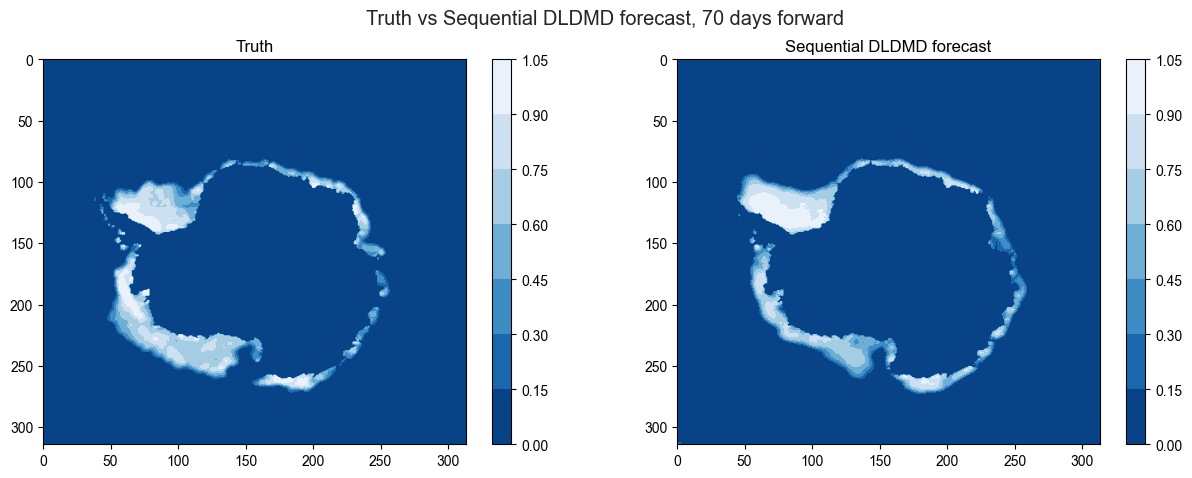

In [ ]:
"""plots using  window = 1, history = 2, svd = 5"""

fig_1, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

sns.color_palette("crest", as_cmap=True)
palette = get_hex("Aluterus_scriptus", keep_first_n=5)

ax_1 = ax1.contourf(X1_[71], cmap=plt.get_cmap('Blues_r'))
ax1.set_title("Truth")
ax1.set_ylim(314, 0)
cbar1 = fig_1.colorbar(ax_1)

ax_2 = ax2.contourf(pred_dec.numpy()[71], cmap=plt.get_cmap('Blues_r'))
ax2.set_title("Sequential DLDMD forecast")
ax2.set_ylim(314, 0)
cbar2 = fig_1.colorbar(ax_2)

sns.set(style="darkgrid")

fig_1.suptitle("Truth vs Sequential DLDMD forecast, 70 days forward")
plt.show()

In [ ]:
# fig_2, (ax3, ax4) = plt.subplots(1,2, figsize=(15,5))

# ax_3 = ax3.contourf(X1_[179], cmap=plt.get_cmap('Blues_r'))
# ax3.set_title("Truth")
# ax3.set_ylim(314, 0)
# cbar3 = fig_2.colorbar(ax_3)

# ax_4 = ax4.contourf(pred_dec.numpy()[179], cmap=plt.get_cmap('Blues_r'))
# ax4.set_title("Sequential DLDMD forecast")
# ax4.set_ylim(314, 0)
# cbar4 = fig_2.colorbar(ax_4)

# sns.set(style="darkgrid")

# fig_2.suptitle("Truth vs Sequential DLDMD forecast, 180 days forward")
# plt.show()

In [ ]:
dmd_avg_stat_df = pd.concat(dmd_avg_stat, ignore_index = True)
dmd_MSE_df = pd.concat(dmd_MSE, ignore_index = True)
dmd_MAE_df = pd.concat(dmd_MAE, ignore_index = True)
dmd_IIEE_df = pd.concat(dmd_IIEE, ignore_index = True)
dmd_latent_recon_df = pd.concat(dmd_latent_recon, ignore_index = True)
dmd_latent_fwd_df = pd.concat(dmd_latent_fwd, ignore_index = True)

#latent_space_pred = pd.concat(latent_space_pred, ignore_index = True)
#latent_space_true = pd.concat(latent_space_true, ignore_index = True)
dmd_pred_integral_df = pd.concat(dmd_pred_integral, ignore_index = True)
dmd_true_integral_df = pd.concat(dmd_true_integral, ignore_index = True)

In [ ]:
column_indices = [0,1,2,3,4,5,6,7]
new_names = ['Window','History','SVD rank','latent_recon_mse','latent_fwd_mse','MSE','MAE', 'IIEE', ]
old_names = dmd_avg_stat_df.columns[column_indices]
dmd_avg_stat_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)


column_indices = [0,1,2]
new_names = ['Window','History','SVD rank']
old_names = dmd_MSE_df.columns[column_indices]
dmd_MSE_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

old_names = dmd_MAE_df.columns[column_indices]
dmd_MAE_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

old_names = dmd_IIEE_df.columns[column_indices]
dmd_IIEE_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

old_names = dmd_latent_recon_df.columns[column_indices]
dmd_latent_recon_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

old_names = dmd_latent_fwd_df.columns[column_indices]
dmd_latent_fwd_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

old_names = dmd_pred_integral_df.columns[column_indices]
dmd_pred_integral_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

old_names = dmd_true_integral_df.columns[column_indices]
dmd_true_integral_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

In [ ]:
pd_list = [dmd_MSE_df,dmd_MAE_df,dmd_IIEE_df,dmd_latent_recon_df,dmd_pred_integral_df,dmd_true_integral_df,dmd_avg_stat_df]
pd_sheets = ['dmd_MSE_df','dmd_MAE_df','dmd_IIEE_df','dmd_latent_recon_df','dmd_pred_integral_df','dmd_true_integral_df','dmd_avg_stat_df']


# dmd_avg_stat_df.to_csv(stats_dir + "Seq_DMD_avg_stat_df.csv")
# dmd_latent_recon_df.to_csv(stats_dir + "Seq_DMD_latentrecon_stat_df.csv")
# dmd_latent_fwd_df.to_csv(stats_dir + "Seq_DMD_avg_latentfwd_df.csv")

multiple_dfs_to_excel(pd_list,pd_sheets, stats_dir + "seq_dldmd_all_stats.xlsx")

In [ ]:
def melf_frame_lineplot(input_mae,input_iiee, qry):
    temp_df = input_mae.query(qry)
    temp_df2 = input_iiee.query(qry)

    temp_df = temp_df[temp_df.columns[1:]].melt(['SVD rank', 'History'], var_name = 'pred_day',value_name = 'MAE' )
    temp_df['pred_day'] = temp_df['pred_day']-2

    temp2_df = temp_df2[temp_df2.columns[1:]].melt(['SVD rank', 'History'], var_name = 'pred_day',value_name = 'IIEE' )
    temp2_df['pred_day'] = temp2_df['pred_day']-2

    return temp_df, temp2_df

In [ ]:
melted_dfs = []
title_list = []

for i in best_win_his:
    m,n,o = i
    input_qry = 'Window == {} & History == {} & `SVD rank` == {}'.format(m,n,o)

    out_df1, out_df2 = melf_frame_lineplot(dmd_MAE_df, dmd_IIEE_df, input_qry)
    melted_dfs.append(out_df1)
    melted_dfs.append(out_df2)
    if m == 1:
        temp_title = "{}-years of historical data with SVD rank: {}".format(n,o)
    else:
        temp_title = "{}-day moving average window using {}-years of historical data with SVD rank:{}".format(m,n,o)
    title_list.append(temp_title)

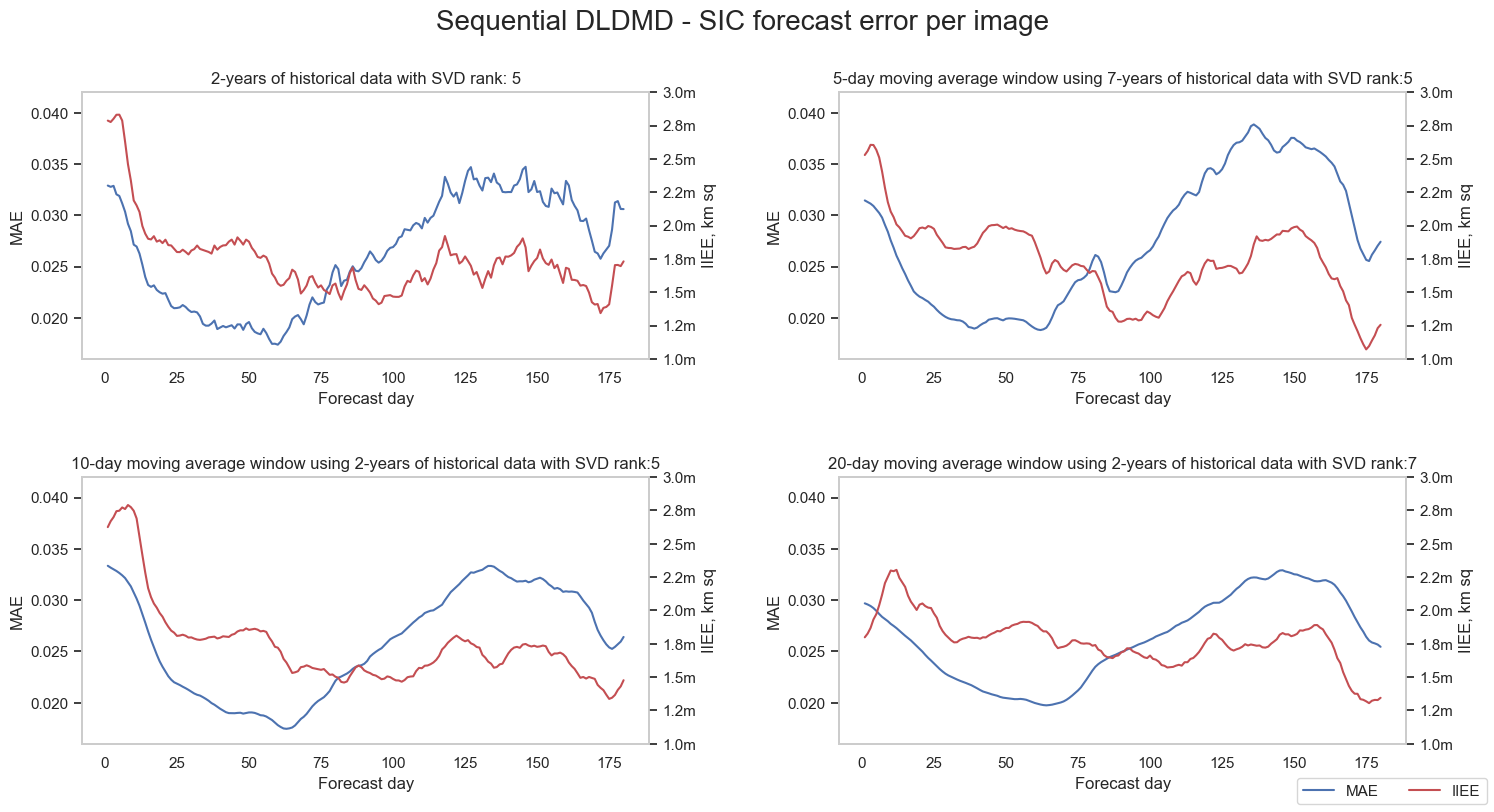

In [ ]:
import seaborn as sns

sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(15, 8))

ax1 = sns.lineplot(melted_dfs[0], x='pred_day', y = 'MAE', label ='MAE', ax =axs[0][0] )
ax1.grid(False)
ax1.set(xlabel='Forecast day')
ax1.set_ylim([0.016, 0.042])
ax1.title.set_text(title_list[0])

ax2 = axs[0][0].twinx()
sns.lineplot(data=melted_dfs[1], x='pred_day', y = 'IIEE',color="r", ax=ax2, label ='IIEE')
ax2.yaxis.set_major_formatter(formatter_mil)
ax2.grid(False)
ax2.set(ylabel='IIEE, km sq')
ax2.set_ylim([1e6, 3.0e6])

##################################

ax3 = sns.lineplot(melted_dfs[2], x='pred_day', y = 'MAE', label ='_MAE', ax =axs[0][1] )
ax3.grid(False)
ax3.set(xlabel='Forecast day')
ax3.set_ylim([0.016, 0.042])
ax3.title.set_text(title_list[1])

ax4 = axs[0][1].twinx()
sns.lineplot(data=melted_dfs[3], x='pred_day', y = 'IIEE',color="r", ax=ax4, label ='_IIEE')
ax4.yaxis.set_major_formatter(formatter_mil)
ax4.grid(False)
ax4.set(ylabel='IIEE, km sq')
ax4.set_ylim([1e6, 3.0e6])

################################################
ax5 = sns.lineplot(melted_dfs[4], x='pred_day', y = 'MAE', label ='_MAE', ax =axs[1][0] )
ax5.grid(False)
ax5.set(xlabel='Forecast day')
ax5.set_ylim([0.016, 0.042])
ax5.title.set_text(title_list[2])

ax6 = axs[1][0].twinx()
sns.lineplot(data=melted_dfs[5], x='pred_day', y = 'IIEE',color="r", ax=ax6, label ='_IIEE')
ax6.yaxis.set_major_formatter(formatter_mil)
ax6.grid(False)
ax6.set(ylabel='IIEE, km sq')
ax6.set_ylim([1e6, 3.0e6])

####################################################

ax7 = sns.lineplot(melted_dfs[6], x='pred_day', y = 'MAE', label ='_MAE', ax =axs[1][1] )
ax7.grid(False)
ax7.set(xlabel='Forecast day')
ax7.set_ylim([0.016, 0.042])
ax7.title.set_text(title_list[3])


ax8 = axs[1][1].twinx()
sns.lineplot(data=melted_dfs[7], x='pred_day', y = 'IIEE',color="r", ax=ax8, label ='_IIEE')
ax8.yaxis.set_major_formatter(formatter_mil)
ax8.grid(False)
ax8.set(ylabel='IIEE, km sq')
ax8.set_ylim([1e6, 3.0e6])

#ax8.legend(loc = 'lower right')

#handles, labels = plt.gca().get_legend_handles_labels()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]

lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.legend(lines, labels, loc="lower right", ncol=2)

#fig.subplots_adjust(hspace=0.1)
fig.suptitle("Sequential DLDMD - SIC forecast error per image", size = 20, y=1)

axis_list = [ax1,ax2]

for i in axis_list: i.get_legend().remove()

#ax8.get_legend().remove()
#plt.show()
plt.tight_layout(h_pad=3, w_pad = 3)


In [ ]:
def melt_frame_lineplot_any(input_mae,metric, qry):
    temp_df = input_mae.query(qry)

    temp_df = temp_df[temp_df.columns[1:]].melt(['SVD rank', 'History'], var_name = 'pred_day',value_name = metric )
    temp_df['pred_day'] = temp_df['pred_day']-2

    return temp_df

In [ ]:
melted_int_dfs = []
title_int_list = []

for i in best_win_his:
    m,n,o = i
    input_qry = 'Window == {} & History == {} & `SVD rank` == {}'.format(m,n,o)

    out_df1 = melt_frame_lineplot_any(dmd_true_integral_df,"True" , input_qry)
    out_df2 = melt_frame_lineplot_any(dmd_pred_integral_df,"Pred" , input_qry)
    melted_int_dfs.append(out_df1)
    melted_int_dfs.append(out_df2)
    
    if m == 1:
        temp_title = "{}-years of historical data with SVD rank: {}".format(n,o)
    else:
        temp_title = "{}-day moving average window using {}-years of historical data with SVD rank:{}".format(m,n,o)
    title_int_list.append(temp_title)

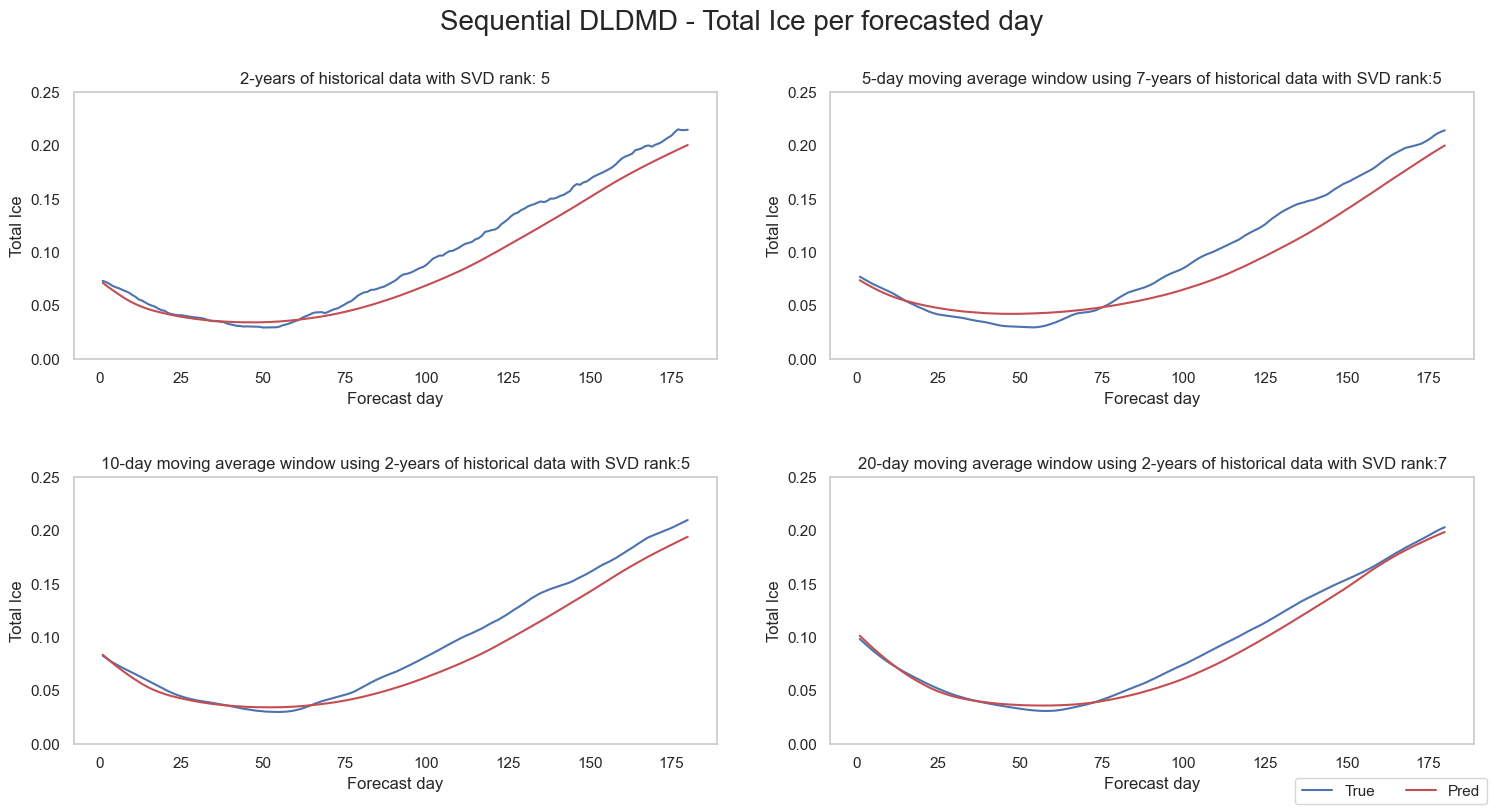

In [ ]:
import seaborn as sns

sns.set(style="whitegrid")
fig_int, axs_int = plt.subplots(2, 2, figsize=(15, 8))

ax1_int = sns.lineplot(melted_int_dfs[0], x='pred_day', y = 'True', label ='True', ax =axs_int[0][0], color="b" )
sns.lineplot(data=melted_int_dfs[1], x='pred_day', y = 'Pred',color="r", ax=axs_int[0][0], label ='Pred')
ax1_int.grid(False)
ax1_int.set(xlabel='Forecast day')
ax1_int.title.set_text(title_int_list[0])
ax1_int.set_ylim([0.0, 0.25])
ax1_int.set(ylabel="Total Ice")

ax2_int = sns.lineplot(melted_int_dfs[2], x='pred_day', y = 'True', label ='_True', ax =axs_int[0][1], color="b" )
sns.lineplot(data=melted_int_dfs[3], x='pred_day', y = 'Pred',color="r", ax=axs_int[0][1], label ='_Pred')
ax2_int.grid(False)
ax2_int.set(xlabel='Forecast day')
ax2_int.title.set_text(title_int_list[1])
ax2_int.set_ylim([0.0, 0.25])
ax2_int.set(ylabel="Total Ice")

ax3_int = sns.lineplot(melted_int_dfs[4], x='pred_day', y = 'True', label ='_True', ax =axs_int[1][0], color="b" )
sns.lineplot(data=melted_int_dfs[5], x='pred_day', y = 'Pred',color="r", ax=axs_int[1][0], label ='_Pred')
ax3_int.grid(False)
ax3_int.set(xlabel='Forecast day')
ax3_int.title.set_text(title_int_list[2])
ax3_int.set_ylim([0.0, 0.25])
ax3_int.set(ylabel="Total Ice")


ax4_int = sns.lineplot(melted_int_dfs[6], x='pred_day', y = 'True', label ='_True', ax =axs_int[1][1], color="b" )
sns.lineplot(data=melted_int_dfs[7], x='pred_day', y = 'Pred',color="r", ax=axs_int[1][1], label ='_Pred')
ax4_int.grid(False)
ax4_int.set(xlabel='Forecast day')
ax4_int.title.set_text(title_int_list[3])
ax4_int.set_ylim([0.0, 0.25])
ax4_int.set(ylabel="Total Ice")


lines_labels = [ax.get_legend_handles_labels() for ax in fig_int.axes]

lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig_int.legend(lines, labels, loc="lower right", ncol=2)

#fig.subplots_adjust(hspace=0.1)
fig_int.suptitle("Sequential DLDMD - Total Ice per forecasted day", size = 20, y=1)

axis_list = [ax1_int]

for i in axis_list: i.get_legend().remove()

#ax8.get_legend().remove()
#plt.show()
plt.tight_layout(h_pad=3, w_pad = 3)


In [ ]:
melted_latent_dfs = []
title_latent_list = []

for i in best_win_his:
    m,n,o = i
    #input_qry = 'Window == {} & History == {} & `SVD rank` == {}'.format(m,n,o)
    for idx, j in enumerate(latent_space_pred):
        if j[0] == i:
            melted_latent_dfs.append(j[1])
            melted_latent_dfs.append(latent_space_true[idx][1])
        
            if m == 1:
                temp_title = "{}-years of historical data with SVD rank: {}".format(n,o)
            else:
                temp_title = "{}-day moving average window using {}-years of historical data with SVD rank:{}".format(m,n,o)
            title_latent_list.append(temp_title)



c:\ProgramData\miniconda3\envs\autoenc1\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\ProgramData\miniconda3\envs\autoenc1\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


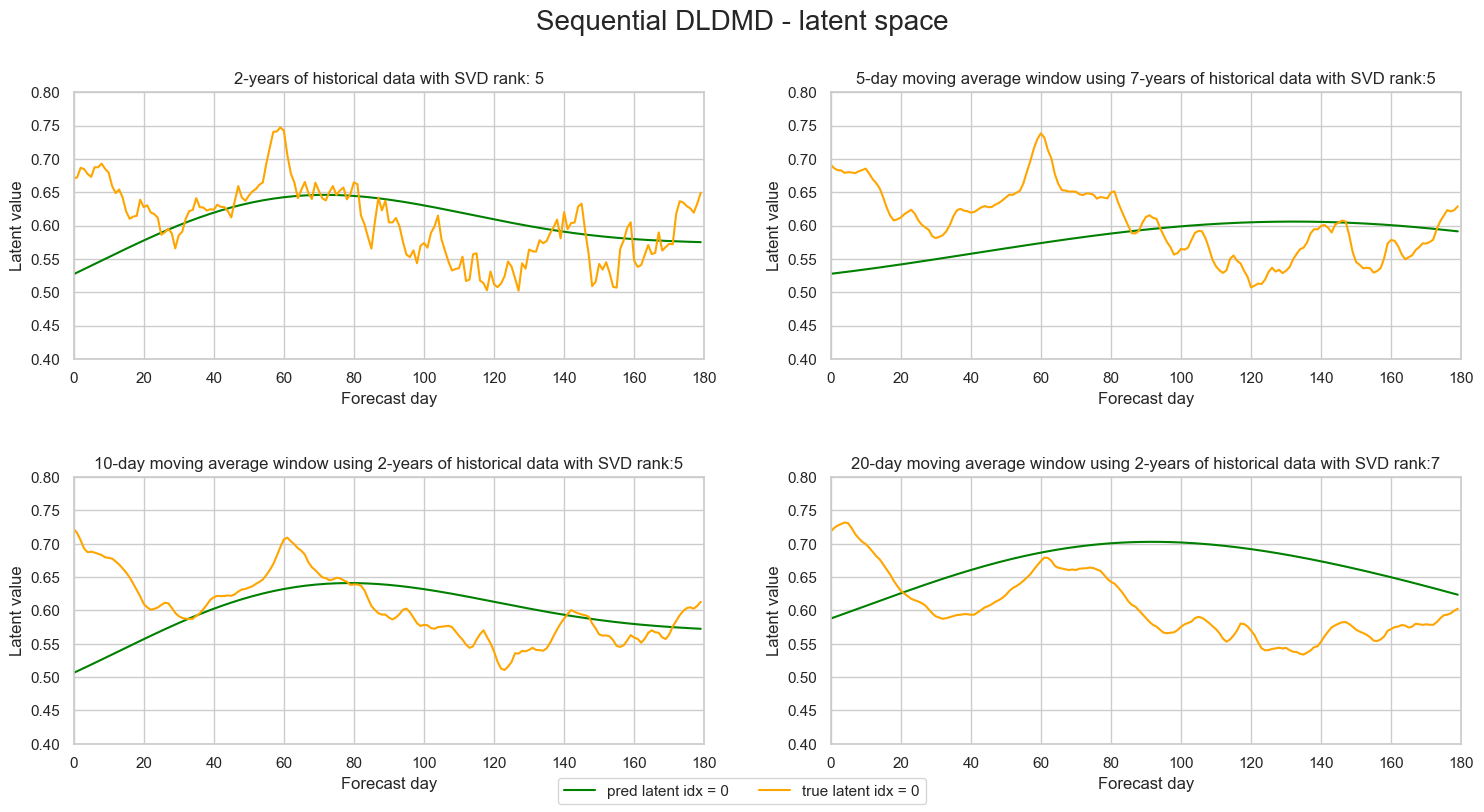

In [ ]:
import seaborn as sns


latent_idx = 0
sns.set(style="whitegrid")
fig_lat, axs_lat = plt.subplots(2, 2, figsize=(15, 8), constrained_layout=False)

axs_lat[0][0].plot(melted_latent_dfs[0][:,latent_idx], label="pred latent idx = 0", color='green')
axs_lat[0][0].plot(melted_latent_dfs[1][:,latent_idx], label="true latent idx = 0", color='orange')

# axs_lat[0][0].plot(melted_latent_dfs[0][:,2])
# axs_lat[0][0].plot(melted_latent_dfs[1][:,2])
axs_lat[0][0].set_xlim(0, 180)
axs_lat[0][0].set_ylim(0.4, 0.8)
axs_lat[0][0].set_xlabel('Forecast day')
axs_lat[0][0].set_ylabel('Latent value')
axs_lat[0][0].set_title(title_latent_list[0])

axs_lat[0][1].plot(melted_latent_dfs[2][:,latent_idx], label="_pred latent idx = 0",color='green')
axs_lat[0][1].plot(melted_latent_dfs[3][:,latent_idx], label="_true latent idx = 0",color='orange')
axs_lat[0][1].set_xlim(0, 180)
axs_lat[0][1].set_ylim(0.4, 0.8)
axs_lat[0][1].set_xlabel('Forecast day')
axs_lat[0][1].set_ylabel('Latent value')
axs_lat[0][1].set_title(title_latent_list[1])

axs_lat[1][0].plot(melted_latent_dfs[4][:,latent_idx], label="_pred latent idx = 0",color='green')
axs_lat[1][0].plot(melted_latent_dfs[5][:,latent_idx], label="_true latent idx = 0",color='orange')
axs_lat[1][0].set_xlim(0, 180)
axs_lat[1][0].set_ylim(0.4, 0.8)
axs_lat[1][0].set_xlabel('Forecast day')
axs_lat[1][0].set_ylabel('Latent value')
axs_lat[1][0].set_title(title_latent_list[2])

axs_lat[1][1].plot(melted_latent_dfs[6][:,latent_idx], label="_pred latent idx = 0",color='green')
axs_lat[1][1].plot(melted_latent_dfs[7][:,latent_idx], label="_true latent idx = 0",color='orange')
axs_lat[1][1].set_xlim(0, 180)
axs_lat[1][1].set_ylim(0.4, 0.8)
axs_lat[1][1].set_xlabel('Forecast day')
axs_lat[1][1].set_ylabel('Latent value')
axs_lat[1][1].set_title(title_latent_list[3])

fig_lat.suptitle("Sequential DLDMD - latent space", size = 20, y=1)

lines_labels = [ax.get_legend_handles_labels() for ax in fig_lat.axes]

lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig_lat.legend(lines, labels, loc="lower center", ncol=2)

plt.tight_layout(h_pad=3, w_pad = 3)

In [ ]:
# with open(r'../outputs/seq_dmd_stats/all_seqdmd_stats_' + time.strftime("%Y%m%d"), 'wb') as output:
#      pickle.dump([dmd_avg_stat_df,dmd_MSE_df, dmd_MAE_df, dmd_IIEE_df,dmd_latent_recon_df, dmd_latent_fwd_df], output)

In [ ]:
# with open(r'../outputs/seq_dmd_stats/all_seqdmd_stats_20240815', 'rb') as f:
#     loaded_df = pickle.load(f)

# dmd_avg_stat_df,dmd_MSE_df, dmd_MAE_df, dmd_IIEE_df,dmd_latent_recon_df, dmd_latent_fwd_df = loaded_df

In [ ]:
# dmd_avg_stat_df.to_csv(stats_dir + "Seq_DMD_avg_stat_df.csv")

# dmd_latent_recon_df.to_csv(stats_dir + "Seq_DMD_latentrecon_stat_df.csv")
# dmd_latent_fwd_df.to_csv(stats_dir + "Seq_DMD_avg_latentfwd_df.csv")

In [ ]:
import seaborn as sns

def query_boxplot(qry, metric, input_df, plt_title,shade = "BluetoGray_8", yxformat = None):
    
    temp_df = input_df.query(qry)
    melt_df = temp_df[temp_df.columns[1:]].melt(['SVD rank', 'History'], var_name = 'pred_day',value_name = metric )

    fig, axs = plt.subplots(1, 1, figsize=(16, 7))

    #palette = get_hex("Bmlunge")
    sns.set_theme()
    palette = get_hex(shade, keep_first_n=8)
    sns.set_style("darkgrid")
    ax_sns = sns.boxplot(data= melt_df, x = 'SVD rank', y = metric , hue = "History" , ax = axs, palette= palette)
    #ax_sns.set_title("Distribution of IIEE  - Forecasted SIC images")
    ax_sns.set_title(plt_title)

    if yxformat is not None:
        ax_sns.yaxis.set_major_formatter(yxformat)

    l = ax_sns.legend(title= 'History:', bbox_to_anchor=(0.2, -0.07), ncol = 5, loc = 'center', frameon=False)
    #sns.move_legend(ax_sns, "center", bbox_to_anchor=(0.5, -0.15), ncol = 5, frameon=False)
    l.get_title().set_position((-190, -21))

    #sns.set_style()
    plt.plot()

C:\Users\MITESH\AppData\Local\Temp\ipykernel_20000\2182086002.py:14: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax_sns = sns.boxplot(data= melt_df, x = 'SVD rank', y = metric , hue = "History" , ax = axs, palette= palette)
C:\Users\MITESH\AppData\Local\Temp\ipykernel_20000\2182086002.py:14: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax_sns = sns.boxplot(data= melt_df, x = 'SVD rank', y = metric , hue = "History" , ax = axs, palette= palette)
C:\Users\MITESH\AppData\Local\Temp\ipykernel_20000\2182086002.py:14: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax_sns = sns.boxplot(data= melt_df, x = 'SVD rank', y = metric , hue = "History" , ax = axs, palette= palette)
C:\Users\MITESH\AppData\Local\Temp\ipykernel_20000\2182086002.py:14: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax_sns 

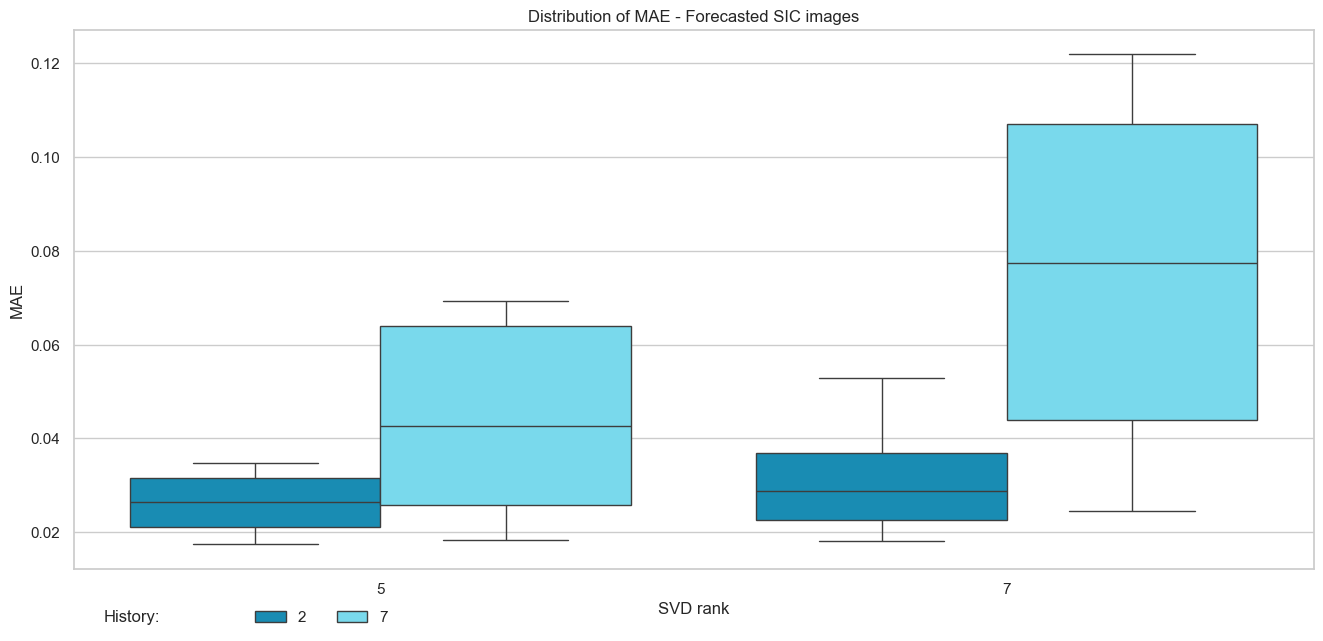

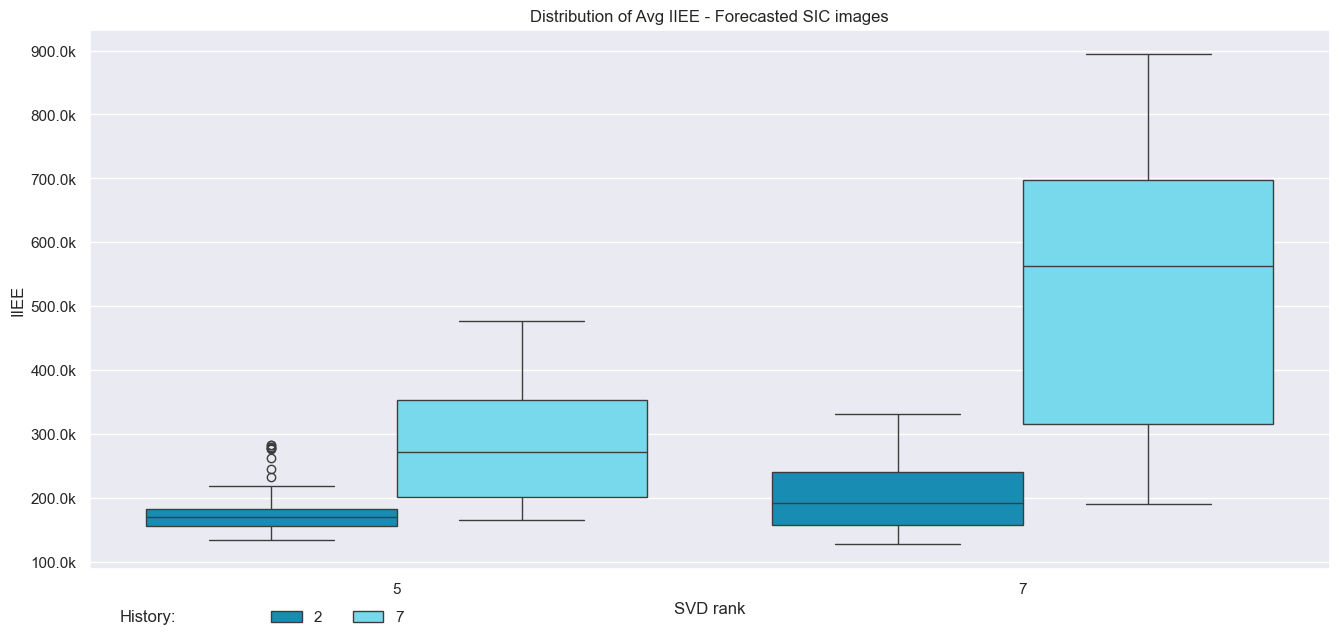

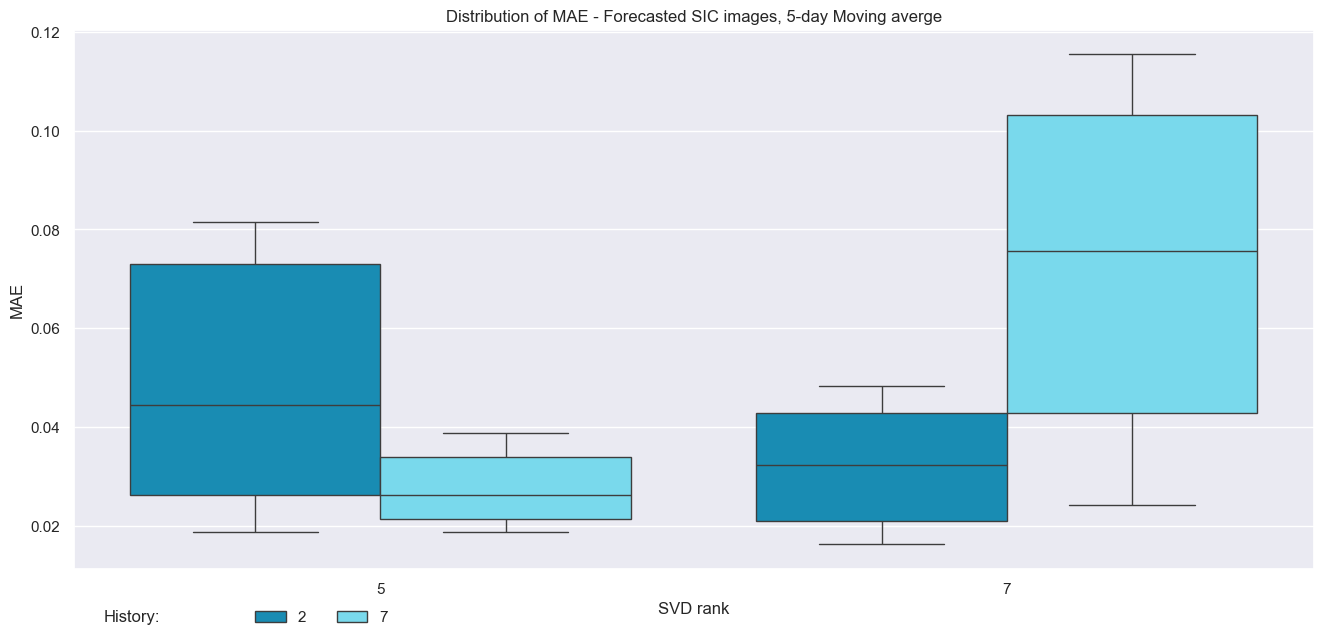

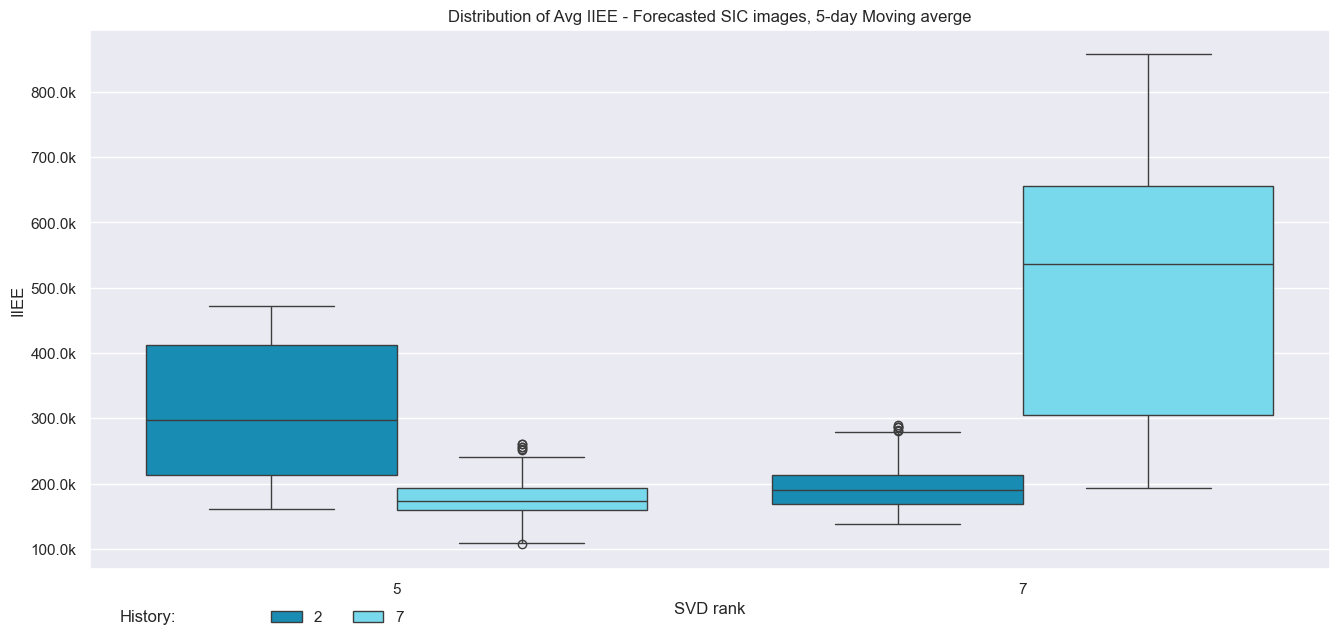

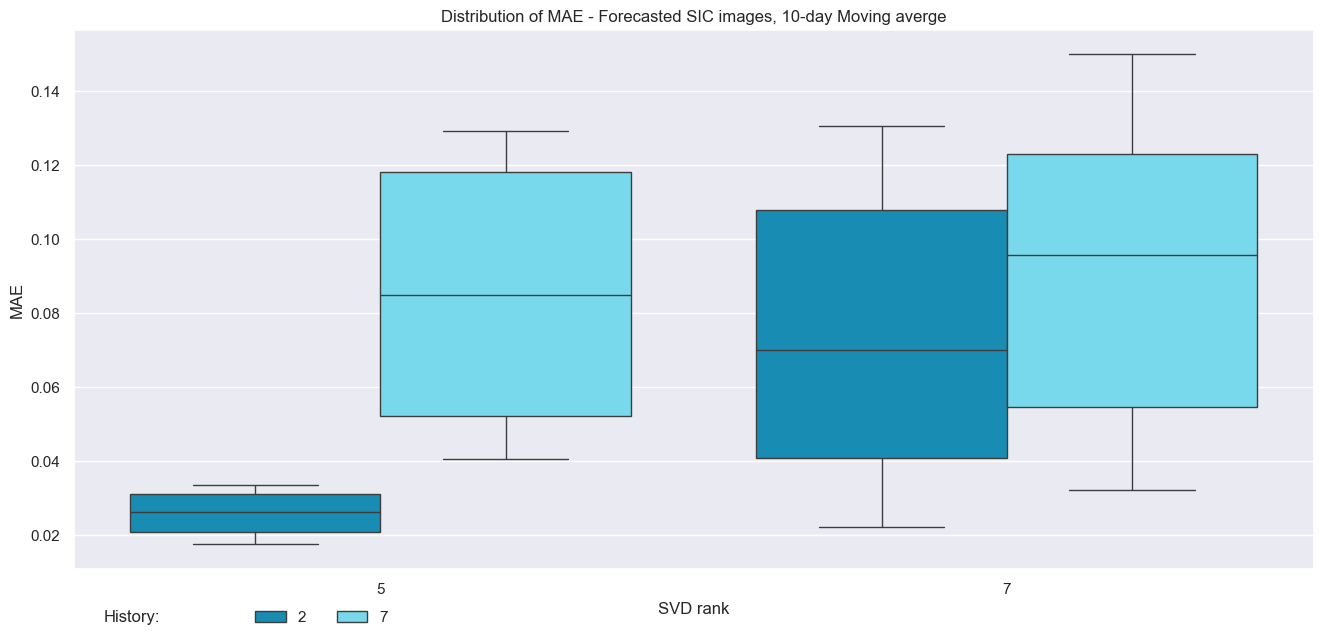

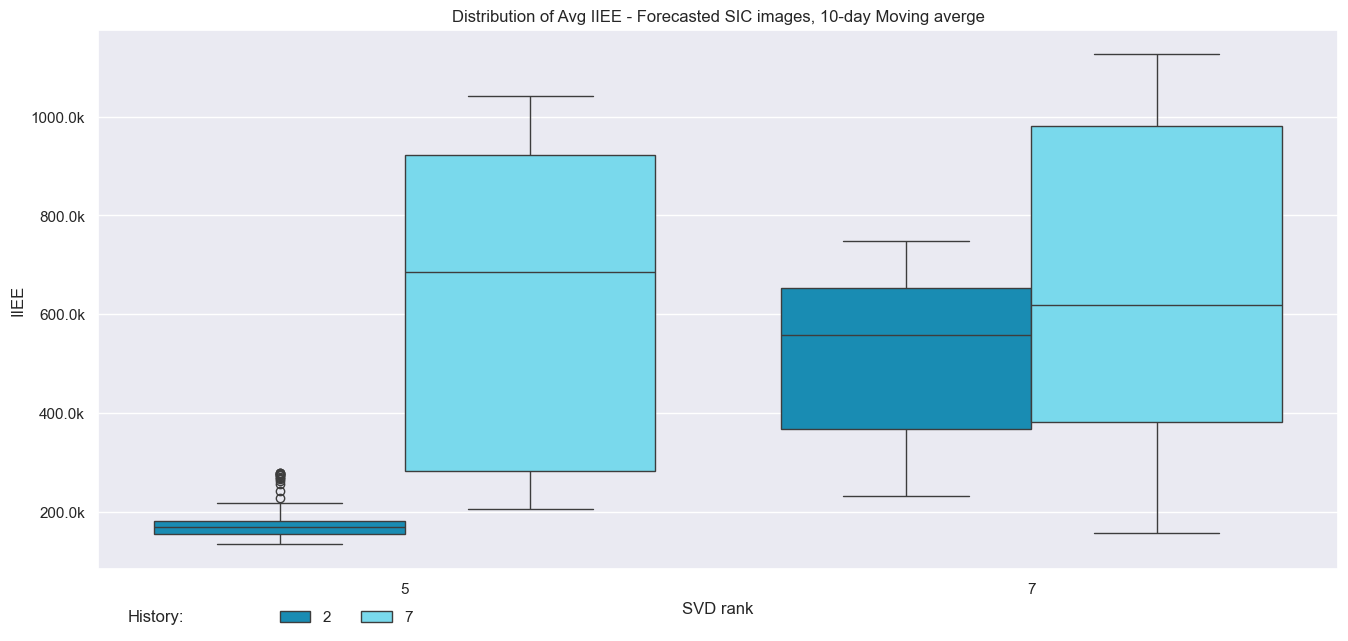

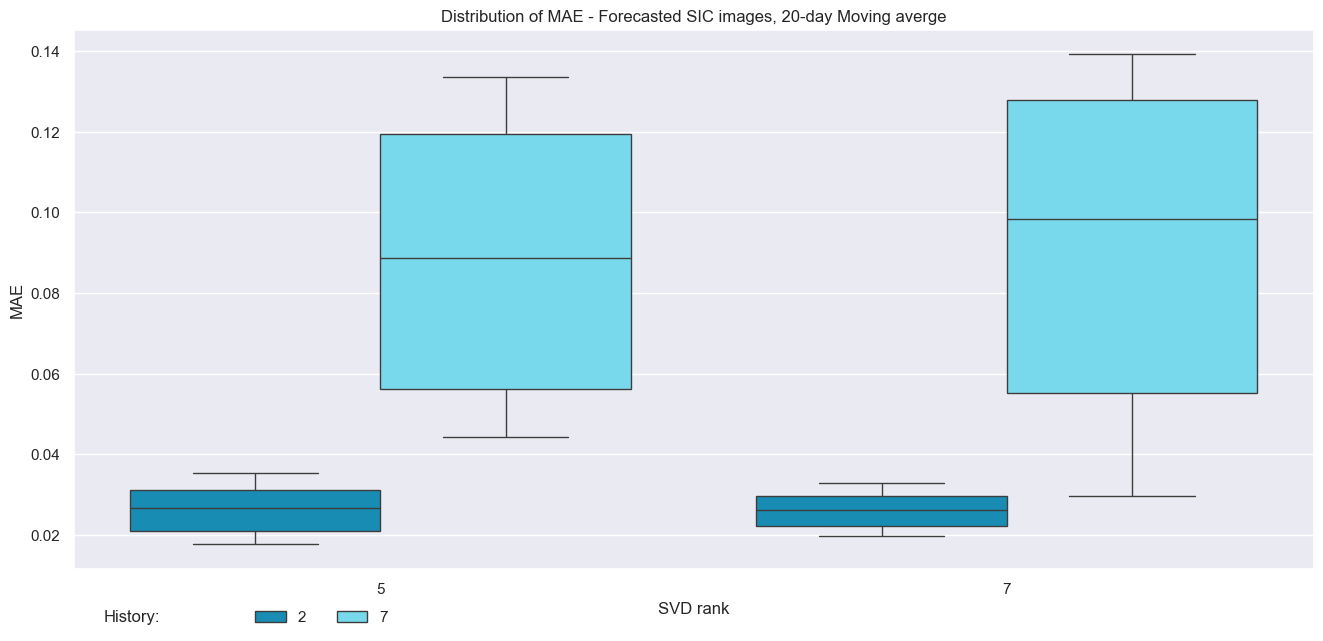

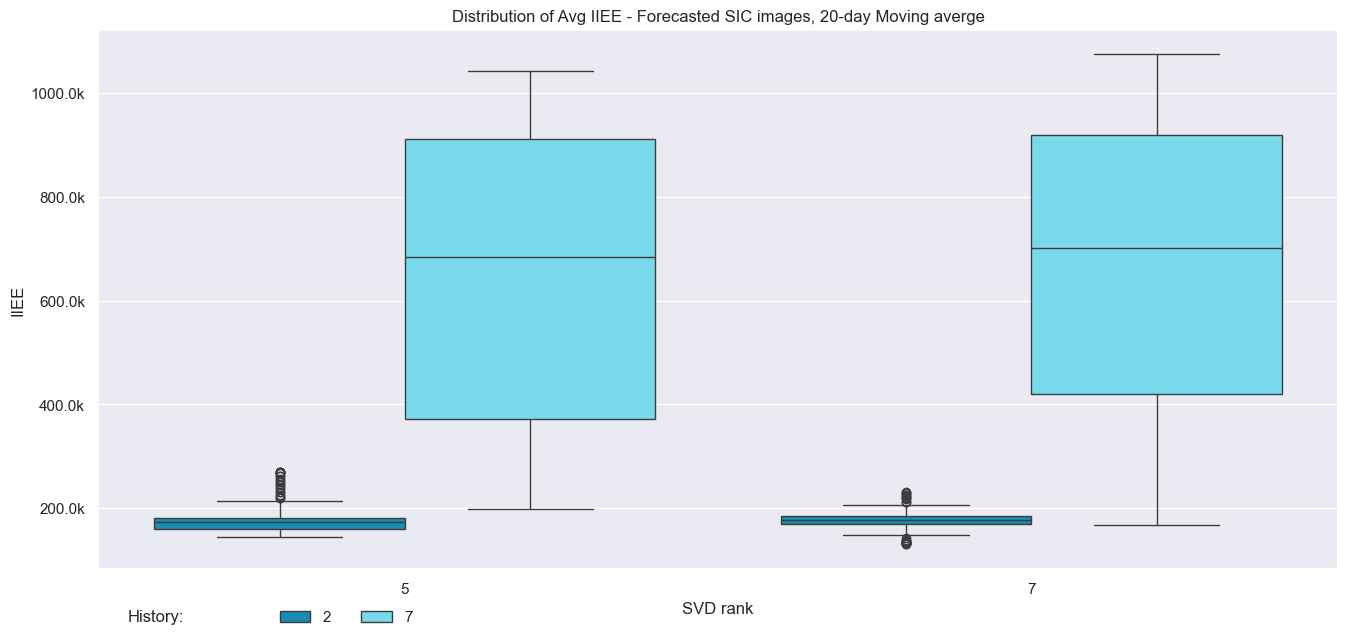

In [ ]:
win = 1
svd_u = 11
svd_l = 2

input_qry = 'Window == {} & History in (2,5,7,10) & `SVD rank` < {} & `SVD rank` > {}'.format(win, svd_u, svd_l)

query_boxplot(input_qry, "MAE", dmd_MAE_df,"Distribution of MAE - Forecasted SIC images" )
query_boxplot(input_qry, "IIEE", dmd_IIEE_df,"Distribution of Avg IIEE - Forecasted SIC images", yxformat = formatter)

for i in [5,10,20]:
    input_qry = 'Window == {} & History in (2,5,7,10) & `SVD rank` < {} & `SVD rank` > {}'.format(i, svd_u, svd_l)
    query_boxplot(input_qry, "MAE", dmd_MAE_df,"Distribution of MAE - Forecasted SIC images, {}-day Moving averge".format(i) )
    query_boxplot(input_qry, "IIEE", dmd_IIEE_df,"Distribution of Avg IIEE - Forecasted SIC images, {}-day Moving averge".format(i), yxformat = formatter)